# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
#TODO -diana
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#np.random.seed(42)

#import re
#from nltk.tokenize import word_tokenize
#from nltk.stem import WordNetLemmatizer
#from sklearn.metrics import confusion_matrix
#from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
#from sklearn.pipeline import Pipeline
#from sklearn.multioutput import MultiOutputClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import classification_report



# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head(20)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


C:\Users\dianas\AppData\Local\Temp/ipykernel_34848/317968091.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  profile.hist(ax = ax);


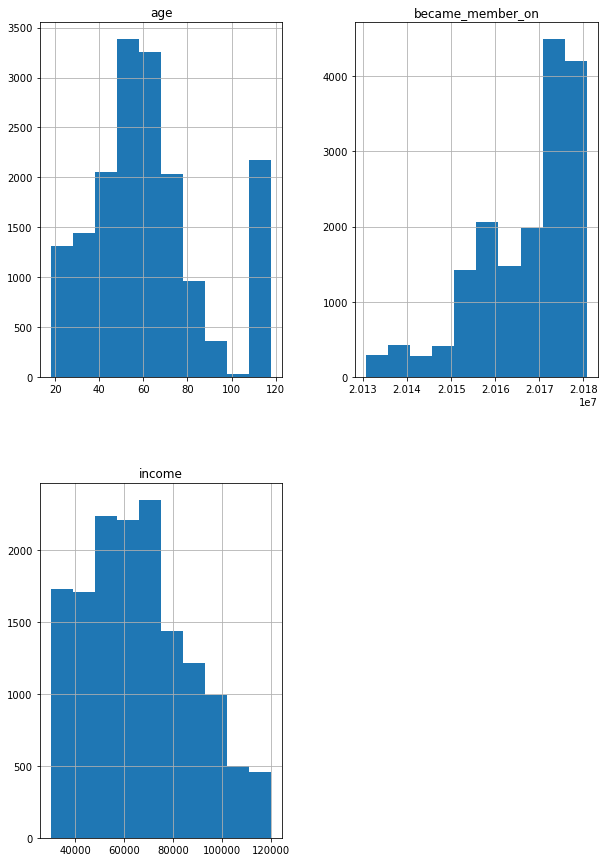

In [5]:
fig = plt.figure(figsize = (10,15));
ax = fig.gca();
profile.hist(ax = ax);

## Data Exploration

In [6]:
profile.query("age == 118")

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [7]:
profile.query("age != 118").age.mean()

54.39352445193929

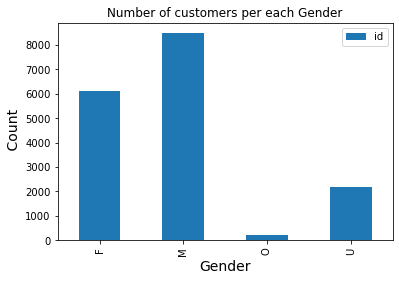

In [8]:
# Gender distribution
profile.fillna('U', inplace=False).groupby('gender').agg({
    'id':'count'}).plot(kind="bar")

plt.ylabel(' Count', fontsize=14)
plt.xlabel('Gender', fontsize=14)
plt.title("Number of customers per each Gender");
plt.show()

In [9]:
mp = profile.query("gender=='M'").shape[0]*100/profile.shape[0]
fp = profile.query("gender=='F'").shape[0]*100/profile.shape[0]
op = profile.query("gender=='O'").shape[0]*100/profile.shape[0]
up = profile.query("gender not in ('M','F','O')").shape[0]*100/profile.shape[0]

print("Percentage of males is ", "%.2f" % mp, "%")
print("Percentage of females is ", "%.2f" % fp, "%")
print("Percentage of others is ", "%.2f" % op, "%")
print("Percentage of unknown is ", "%.2f" % up, "%")

Percentage of males is  49.91 %
Percentage of females is  36.05 %
Percentage of others is  1.25 %
Percentage of unknown is  12.79 %


We can observe that half of population are males


In [10]:
# have a look at range of ages 
profile.age.unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99], dtype=int64)

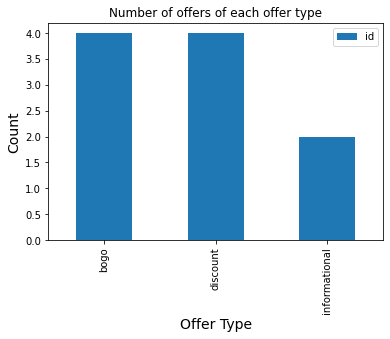

In [11]:
# Offer distribution
portfolio.groupby('offer_type').agg({
    'id':'count'}).plot(kind="bar")

plt.ylabel('Count', fontsize=14)
plt.xlabel('Offer Type', fontsize=14)
plt.title("Number of offers of each offer type");
plt.show()

In [12]:
# have a look at event types
transcript.event.unique()


array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [13]:
# check what possible key combinations we can have in the value column 
transcript.value.apply(lambda x : ','.join(x.keys())).unique()

array(['offer id', 'amount', 'offer_id,reward'], dtype=object)

In [14]:
# split out keys from value column into separate columns
transcript2 = pd.DataFrame(transcript['value'].values.tolist(), index=transcript.index)
transcript2.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [15]:
# have a look at reward values
transcript2.reward.unique()

array([nan,  2.,  5., 10.,  3.])

In [16]:
# have a look at some rows that have reward not null 
transcript2.query('reward == reward').head()

,offer id,amount,offer_id,reward
12658,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
12672,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
12679,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
12692,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0
12697,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0


In [17]:
# join value keys column together with original df
transcript3 = transcript.merge(transcript2, left_index=True, right_index=True)
# rename the columns to be more clear
transcript3 = transcript3.rename(columns={'offer_id': 'completed_offer_id', 'offer id' : 'offer_id'})
transcript3.head()

,person,event,value,time,offer_id,amount,completed_offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


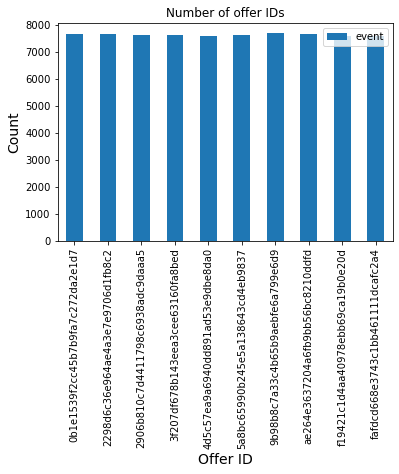

In [18]:
# Offer distribution
transcript3.query('event=="offer received"').groupby('offer_id').agg({
    'event':'count'}).plot(kind="bar")

plt.ylabel('Count', fontsize=14)
plt.xlabel('Offer ID', fontsize=14)
plt.title("Number of offer IDs");
plt.show()

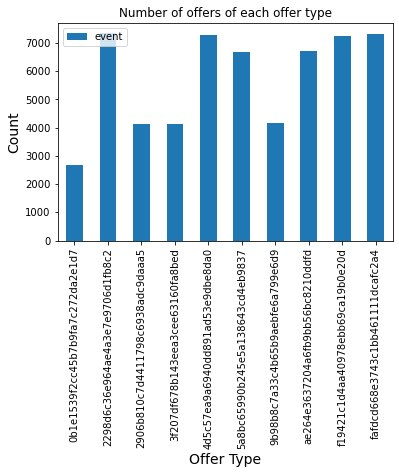

In [19]:
# Offer distribution
transcript3.query('event=="offer viewed"').groupby('offer_id').agg({
    'event':'count'}).plot(kind="bar")

plt.ylabel('Count', fontsize=14)
plt.xlabel('Offer Type', fontsize=14)
plt.title("Number of offers of each offer type");
plt.show()

In [20]:
# have a look at completed offers
transcript3.query('event == "offer completed"').head(100)

,person,event,value,time,offer_id,amount,completed_offer_id,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0
...,...,...,...,...,...,...,...,...
13948,a05d5de8d4314ec19162578f67af3fee,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
13953,33834c812b4e47e4955093ad03f6117a,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0
13965,c0231649f05d40889e3a6e1172303b37,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
13976,3b84fac9ca1148bb96b133ced98f565a,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0


In [21]:
# have a look at a random customer's events
transcript3.query('person == "9fa9ae8f57894cc9a3b8a9bbe0fc1b2f"').head(10)

,person,event,value,time,offer_id,amount,completed_offer_id,reward
36,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,NaN,34.56,NaN,NaN
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
27850,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 21.55},42,NaN,21.55,NaN,NaN
44327,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 32.87},114,NaN,32.87,NaN,NaN
51350,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 19.99},156,NaN,19.99,NaN,NaN
65854,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 20.97},168,NaN,20.97,NaN,NaN
81403,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 31.09},204,NaN,31.09,NaN,NaN
110866,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},336,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN


In [22]:
# create new df that will contain the total nr of trx, customer and amount spent

# first lets have a look at transactions
transactions = transcript3.query('event == "transaction"')
transactions.head()

,person,event,value,time,offer_id,amount,completed_offer_id,reward
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,NaN,0.83,NaN,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,NaN,34.56,NaN,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,NaN,13.23,NaN,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,NaN,19.51,NaN,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,NaN,18.97,NaN,NaN


In [23]:
# group by person to get spending per person
spending_df = transactions.groupby('person').agg({'amount': 'sum','value':'count'})
spending_df

,amount,value
person,,
0009655768c64bdeb2e877511632db8f,127.60,8
00116118485d4dfda04fdbaba9a87b5c,4.09,3
0011e0d4e6b944f998e987f904e8c1e5,79.46,5
0020c2b971eb4e9188eac86d93036a77,196.86,8
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12
...,...,...
fff3ba4757bd42088c044ca26d73817a,580.98,11
fff7576017104bcc8677a8d63322b5e1,29.94,6
fff8957ea8b240a6b5e634b6ee8eafcf,12.15,5


In [24]:
# Process data to get completed informational offers

# merge transcript data with portfolio
tmp = pd.merge(transcript3, portfolio, how="left", left_on="offer_id", right_on="id")

# take only information viewed offers and transactions
tmp2 = tmp.query('(offer_type == "informational" and event == "offer viewed") or event=="transaction"').sort_values('time')

# lets look at a random user
tmp2.query('person == "54890f68699049c2a04d415abc25e717"')    
    
#    print(df.iloc[i]['c1'], df.iloc[i]['c2'])   

,person,event,value,time,offer_id,amount,completed_offer_id,reward_x,reward_y,channels,difficulty,duration,offer_type,id
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,NaN,13.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36917,54890f68699049c2a04d415abc25e717,transaction,{'amount': 21.35},78,NaN,21.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109893,54890f68699049c2a04d415abc25e717,transaction,{'amount': 15.61},330,NaN,15.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145383,54890f68699049c2a04d415abc25e717,transaction,{'amount': 22.39},390,NaN,22.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174369,54890f68699049c2a04d415abc25e717,transaction,{'amount': 7.78},426,NaN,7.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191227,54890f68699049c2a04d415abc25e717,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},468,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,0.0,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
230421,54890f68699049c2a04d415abc25e717,transaction,{'amount': 20.01},534,NaN,20.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299276,54890f68699049c2a04d415abc25e717,transaction,{'amount': 18.48},684,NaN,18.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# loop through the df and count the completed offers by looking for transactions within the offer duration

# a type to hold the offer
class Offer:
  def __init__(self, duration, time, channels):
    self.duration = duration
    self.time = time
    self.channels = channels
        
# hash to hold the last offer seen
last_offer_viewed = {}

# below hashes hold the results
completed_offers = {}
viewed_offers = {}
channels_completed = {}
channels_viewed = {}

for i in range(0, len(tmp2)):
    person = tmp2.iloc[i]['person']
    if tmp2.iloc[i]['event'] == "transaction":
        # check if this transaction is within duration of an offer in the past
        if person in last_offer_viewed and tmp2.iloc[i]['time'] - last_offer_viewed[person].time <= last_offer_viewed[person].duration:
            if person in completed_offers:
                completed_offers[person] += 1
            else:
                completed_offers[person] = 1
                channels_completed[person] = { 'email_completed' : 0, 'mobile_completed' : 0, 'web_completed' : 0 , 'social_completed' : 0 }
                
            for channel in last_offer_viewed[person].channels:
                channels_completed[person][channel+'_completed'] += 1;
                
            del last_offer_viewed[person]
    else:
        # save offer information
        channels = tmp2.iloc[i]['channels']
        last_offer_viewed[person] = Offer(tmp2.iloc[i]['duration']*24,tmp2.iloc[i]['time'],channels)
        if person in viewed_offers:
            viewed_offers[person] += 1
        else:
            viewed_offers[person] = 1
            channels_viewed[person] = { 'email_viewed' : 0, 'mobile_viewed' : 0, 'web_viewed' : 0 , 'social_viewed' : 0 }
            
        for channel in channels:
            channels_viewed[person][channel+'_viewed'] += 1;
            

In [26]:
# nr of information offers that lead to a  transation per cusotmer_id
completed_offers

{'55ff74cf7c3a44f3bd97002c9ed363dc': 1,
 '61e18c335a324e0fbadf97cfc07ddb22': 1,
 'd01a27c670094f73aeee5cf138fa17df': 1,
 '194c17ebab614744a501d5ef67c3b010': 2,
 '8f9b3a14beef4771a37fc05f1d7574d1': 2,
 '22d072830a384100928fbbc313e6184a': 1,
 'ef0523204bd24631adf29b78048dc6ef': 1,
 'd8a7d08af02243ae8ba4206010bb57f9': 1,
 '581ad5ee9b9f438a8856a94b9710ec45': 2,
 '9f1250e13503459b961c2fc777d5d8c2': 1,
 'd86d562ac40c482194fcd54999f82148': 2,
 '2e6aab1dfef6443aa00ab9567c72e4b5': 1,
 '53ee066c1c7540d9b447d19d152e354e': 1,
 'd1e603c73e534afc932dad2a4db51533': 2,
 '0d732f0791d34ef393aa6dee0b260ede': 1,
 '0383a12d3a2d4fbb86ec83bd0c25eead': 1,
 'c9e985e8988f49d29b57b046a07ce995': 1,
 'b66f9cb486024f0d87ab7469e8d7528d': 3,
 '85240db9bdca4e5486b9837ae5ceea59': 2,
 '9da20f64522348e7a8d5006fc232b2b6': 1,
 '5c76370980e54446ada45f7891cfacb3': 1,
 'a08eae366ff245f3bcba710e73899db0': 1,
 'baec6fd421ca41948585242e20df9852': 1,
 'c407a4f4f05f467ba6268b048a75e728': 2,
 'e75f049cf8bd494bac2d4bfdc17679cf': 2,


In [27]:
# have a look at channels viewed data
pd.DataFrame.from_dict(channels_viewed, orient='index')

,email_viewed,mobile_viewed,web_viewed,social_viewed
d1ede868e29245ea91818a903fec04c6,1,1,0,1
b8b9ab5373b34dcabf05b8e39d85718b,1,1,0,1
df6c9f97dc174122b36bcda29e30976b,1,1,0,1
70d03d804b1f4cdd9b807ef0572fcecf,4,4,2,2
55ff74cf7c3a44f3bd97002c9ed363dc,1,1,1,0
...,...,...,...,...
5265f933778d4350b21b2199f432521d,1,1,0,1
df1e6d50effb4af28aff99f69fd3f394,1,1,0,1
c801141ccbd74cb08db4b93cc5917a1e,1,1,0,1
4d3857fcab6344aca68ebe2eaffa32c0,1,1,0,1


In [28]:
# join our results from above together

# convert to dataframes
tmp10 = pd.DataFrame(completed_offers.items(), columns=['person', 'offers_completed'])
tmp11 = pd.DataFrame(viewed_offers.items(), columns=['person', 'offers_viewed'])
tmp12 = pd.DataFrame.from_dict(channels_viewed, orient='index')
tmp13 = pd.DataFrame.from_dict(channels_completed, orient='index')

# merges
info_df = pd.merge(tmp11, tmp10, how='left', on='person')
info_df = pd.merge(info_df, tmp12, how='left', left_on='person', right_index=True)
info_df = pd.merge(info_df, tmp13, how='left', left_on='person', right_index=True)
info_df

,person,offers_viewed,offers_completed,email_viewed,mobile_viewed,web_viewed,social_viewed,email_completed,mobile_completed,web_completed,social_completed
0,d1ede868e29245ea91818a903fec04c6,1,1.0,1,1,0,1,1.0,1.0,0.0,1.0
1,b8b9ab5373b34dcabf05b8e39d85718b,1,1.0,1,1,0,1,1.0,1.0,0.0,1.0
2,df6c9f97dc174122b36bcda29e30976b,1,1.0,1,1,0,1,1.0,1.0,0.0,1.0
3,70d03d804b1f4cdd9b807ef0572fcecf,4,2.0,4,4,2,2,2.0,2.0,2.0,0.0
4,55ff74cf7c3a44f3bd97002c9ed363dc,1,1.0,1,1,1,0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
8246,5265f933778d4350b21b2199f432521d,1,NaN,1,1,0,1,NaN,NaN,NaN,NaN
8247,df1e6d50effb4af28aff99f69fd3f394,1,NaN,1,1,0,1,NaN,NaN,NaN,NaN
8248,c801141ccbd74cb08db4b93cc5917a1e,1,NaN,1,1,0,1,NaN,NaN,NaN,NaN
8249,4d3857fcab6344aca68ebe2eaffa32c0,1,NaN,1,1,0,1,NaN,NaN,NaN,NaN


In [29]:
# get rows with completed offer ids
comp_offer_id = transcript3[~transcript3['completed_offer_id'].isnull()]

comp_offer_id.head(3)

,person,event,value,time,offer_id,amount,completed_offer_id,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0


In [30]:
# get rows with viewed offer ids
offer_viewed = transcript3.query('event == "offer viewed"')

offer_viewed.head(3)

,person,event,value,time,offer_id,amount,completed_offer_id,reward
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [31]:
# join viewed offers with completed ones -> right join to keep viewed but not completed and to remove completed but not viewed
tmp3 = pd.merge(comp_offer_id, offer_viewed, how="right", left_on=['completed_offer_id','person'], right_on=['offer_id','person'])
tmp3.head()

,person,event_x,value_x,time_x,offer_id_x,amount_x,completed_offer_id_x,reward_x,event_y,value_y,time_y,offer_id_y,amount_y,completed_offer_id_y,reward_y
0,389bc3fa690240e798340f5a15918d5c,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,60.0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
1,389bc3fa690240e798340f5a15918d5c,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,600.0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
2,d1ede868e29245ea91818a903fec04c6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN
3,102e9454054946fda62242d2e176fdce,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,6.0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
4,02c083884c7d45b39cc68e1314fec56c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN


In [32]:
# merge portfolio data too
tmp5 = pd.merge(tmp3,portfolio, left_on="offer_id_y" , right_on="id")
tmp5.head()

,person,event_x,value_x,time_x,offer_id_x,amount_x,completed_offer_id_x,reward_x,event_y,value_y,...,offer_id_y,amount_y,completed_offer_id_y,reward_y,reward,channels,difficulty,duration,offer_type,id
0,389bc3fa690240e798340f5a15918d5c,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,60.0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},...,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
1,389bc3fa690240e798340f5a15918d5c,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,600.0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},...,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
2,262ad0fb526a4d53b572007da60cce24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},...,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
3,182e68952b474700b171e21b85c258ac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},...,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
4,6d28f18e91324d358d69d1e4b01f1ace,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,24.0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},...,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d


In [33]:
def f_viewed(channel,channels):
    '''
    This function checks if channel is in the channels list
    
    Inputs:
    channel - the channel to verify
    channels - the list of channels
    
    Outputs:
    returns 1 if found or 0 if channel not found in the list of channels
    '''

    if (channel in channels):
        return 1
    return 0

def f_completed(channel,channels,event):
    '''
    This function checks if channel in the list of channels and event is not NA
    
    Inputs:
    channel - the channel to verify
    channels - the list of channels
    event - the event to verify
    
    Outputs:
    returns 1 if channel found and event is not NA or 0 if channel not found in the list of channels and event is NA
    '''

    if (not pd.isna(event) and channel in channels):
        return 1
    return 0
    
# add columns for each row to separate data for each channel
tmp5['web_viewed'] = tmp5.apply(lambda x: f_viewed("web", x.channels), axis=1)
tmp5['email_viewed'] = tmp5.apply(lambda x: f_viewed("email", x.channels), axis=1)
tmp5['social_viewed'] = tmp5.apply(lambda x: f_viewed("social", x.channels), axis=1)
tmp5['mobile_viewed'] = tmp5.apply(lambda x: f_viewed("mobile", x.channels), axis=1)
tmp5['web_completed'] = tmp5.apply(lambda x : f_completed("web", x.channels,x.event_x), axis=1)
tmp5['email_completed'] = tmp5.apply(lambda x : f_completed("email", x.channels,x.event_x), axis=1)
tmp5['social_completed'] = tmp5.apply(lambda x : f_completed("social", x.channels,x.event_x), axis=1)
tmp5['mobile_completed'] = tmp5.apply(lambda x : f_completed("mobile", x.channels,x.event_x), axis=1)
tmp5

,person,event_x,value_x,time_x,offer_id_x,amount_x,completed_offer_id_x,reward_x,event_y,value_y,...,offer_type,id,web_viewed,email_viewed,social_viewed,mobile_viewed,web_completed,email_completed,social_completed,mobile_completed
0,389bc3fa690240e798340f5a15918d5c,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,60.0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},...,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,1,1,1
1,389bc3fa690240e798340f5a15918d5c,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,600.0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},...,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,1,1,1
2,262ad0fb526a4d53b572007da60cce24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},...,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,0,0,0,0
3,182e68952b474700b171e21b85c258ac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},...,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,0,0,0,0
4,6d28f18e91324d358d69d1e4b01f1ace,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,24.0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},...,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66216,62e9e17c69784b6a82f6630ee3e3e82b,offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,360.0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},...,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,1,1,0,0
66217,62e9e17c69784b6a82f6630ee3e3e82b,offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,684.0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},...,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,1,1,0,0
66218,f8ed60edd102473ab78cd33c6a044d3f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},...,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,0,0,0
66219,345f9431137a49b3963221a55567c4a8,offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,540.0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},...,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,1,1,0,0


In [34]:
# group bogo data by person 
bogo_df = tmp5.query('offer_type == "bogo"').groupby('person').agg({
    'event_y':'count',
    'event_x':'count',
    'reward_x': 'sum',
    'web_viewed':'sum',
    'email_viewed':'sum',
    'mobile_viewed':'sum',
    'social_viewed':'sum',
    'web_completed':'sum',
    'email_completed':'sum',
    'mobile_completed':'sum',
    'social_completed':'sum',
})

# rename columns
bogo_df.rename(columns={'event_y':'offers_viewed','event_x':'offers_completed','reward_x':'total_reward'}, inplace=True)
bogo_df.head(4)

,offers_viewed,offers_completed,total_reward,web_viewed,email_viewed,mobile_viewed,social_viewed,web_completed,email_completed,mobile_completed,social_completed
person,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,1,1,5.0,1,1,1,1,1,1,1,1
00116118485d4dfda04fdbaba9a87b5c,2,0,0.0,2,2,2,2,0,0,0,0
0011e0d4e6b944f998e987f904e8c1e5,1,1,5.0,1,1,1,0,1,1,1,0
0020c2b971eb4e9188eac86d93036a77,1,1,10.0,1,1,1,1,1,1,1,1


In [35]:
# same for discount
discount_df = tmp5.query('offer_type == "discount"').groupby('person').agg({
    'event_y':'count',
    'event_x':'count',
    'reward_x': 'sum',
    'web_viewed':'sum',
    'email_viewed':'sum',
    'mobile_viewed':'sum',
    'social_viewed':'sum',
    'web_completed':'sum',
    'email_completed':'sum',
    'mobile_completed':'sum',
    'social_completed':'sum',
})

discount_df.rename(columns={'event_y':'offers_viewed','event_x':'offers_completed','reward_x':'total_reward'}, inplace=True)
discount_df.head(4)

,offers_viewed,offers_completed,total_reward,web_viewed,email_viewed,mobile_viewed,social_viewed,web_completed,email_completed,mobile_completed,social_completed
person,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,1,1,2.0,1,1,1,1,1,1,1,1
0011e0d4e6b944f998e987f904e8c1e5,2,2,8.0,2,2,1,1,2,2,1,1
0020c2b971eb4e9188eac86d93036a77,2,2,4.0,2,2,2,2,2,2,2,2
0020ccbbb6d84e358d3414a3ff76cffd,1,1,3.0,1,1,1,1,1,1,1,1


In [36]:
# merge informational, bogo and discount dfs together
person_offers_df = pd.merge(info_df, discount_df, how='outer', on='person',suffixes=('_info', '_discount'))
person_offers_df = pd.merge(person_offers_df, bogo_df, how='outer', on='person',suffixes=('_discount', '_bogo'))
person_offers_df = person_offers_df.rename(columns={
    'offers_viewed':'offers_viewed_bogo',
    'offers_completed':'offers_completed_bogo',
    'web_viewed'  : 'web_viewed_bogo',
    'email_viewed' : 'email_viewed_bogo',
    'mobile_viewed' : 'mobile_viewed_bogo',
    'social_viewed' : 'social_viewed_bogo',
    'web_completed' : 'web_completed_bogo',
    'email_completed' : 'email_completed_bogo',
    'mobile_completed' : 'mobile_completed_bogo',
    'social_completed' : 'social_completed_bogo'
})
person_offers_df

,person,offers_viewed_info,offers_completed_info,email_viewed_info,mobile_viewed_info,web_viewed_info,social_viewed_info,email_completed_info,mobile_completed_info,web_completed_info,...,offers_completed_bogo,total_reward_bogo,web_viewed_bogo,email_viewed_bogo,mobile_viewed_bogo,social_viewed_bogo,web_completed_bogo,email_completed_bogo,mobile_completed_bogo,social_completed_bogo
0,d1ede868e29245ea91818a903fec04c6,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0
1,b8b9ab5373b34dcabf05b8e39d85718b,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,1.0,5.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0
2,df6c9f97dc174122b36bcda29e30976b,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0
3,70d03d804b1f4cdd9b807ef0572fcecf,4.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,...,2.0,15.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0
4,55ff74cf7c3a44f3bd97002c9ed363dc,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,5.0,30.0,5.0,5.0,5.0,1.0,5.0,5.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16829,ff95e0a9cdfd4030958762dadcb11e1a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
16830,ffac285a64714aca8efd8d61a5606e84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
16831,ffc77312ccda49fca19506f1cdf44923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0
16832,ffe5257abf8840b395e1ee6b29894637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,5.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0


In [37]:
# now merge in the profile data 
person_offers_profile_df = pd.merge(person_offers_df, profile, how='left', left_on='person', right_on='id')
person_offers_profile_df = pd.merge(person_offers_profile_df, spending_df, how='left', left_on='person',right_on='person')
person_offers_profile_df = person_offers_profile_df.rename(columns={'amount':'total_transactions', 'value':'transaction_count'})
person_offers_profile_df


,person,offers_viewed_info,offers_completed_info,email_viewed_info,mobile_viewed_info,web_viewed_info,social_viewed_info,email_completed_info,mobile_completed_info,web_completed_info,...,email_completed_bogo,mobile_completed_bogo,social_completed_bogo,gender,age,id,became_member_on,income,total_transactions,transaction_count
0,d1ede868e29245ea91818a903fec04c6,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,O,53,d1ede868e29245ea91818a903fec04c6,20170916,52000.0,18.74,5.0
1,b8b9ab5373b34dcabf05b8e39d85718b,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,F,39,b8b9ab5373b34dcabf05b8e39d85718b,20160215,59000.0,43.23,12.0
2,df6c9f97dc174122b36bcda29e30976b,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,M,25,df6c9f97dc174122b36bcda29e30976b,20180120,67000.0,14.71,4.0
3,70d03d804b1f4cdd9b807ef0572fcecf,4.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,1.0,F,56,70d03d804b1f4cdd9b807ef0572fcecf,20180301,78000.0,154.87,7.0
4,55ff74cf7c3a44f3bd97002c9ed363dc,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,5.0,5.0,1.0,F,57,55ff74cf7c3a44f3bd97002c9ed363dc,20170514,73000.0,231.81,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16829,ff95e0a9cdfd4030958762dadcb11e1a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,M,79,ff95e0a9cdfd4030958762dadcb11e1a,20170520,93000.0,60.23,3.0
16830,ffac285a64714aca8efd8d61a5606e84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,M,28,ffac285a64714aca8efd8d61a5606e84,20171022,36000.0,9.63,3.0
16831,ffc77312ccda49fca19506f1cdf44923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,M,37,ffc77312ccda49fca19506f1cdf44923,20170319,70000.0,33.77,9.0
16832,ffe5257abf8840b395e1ee6b29894637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,M,77,ffe5257abf8840b395e1ee6b29894637,20170822,75000.0,63.49,3.0


In [38]:
def calc_ratios(df):
    '''
    This function calculates the conversion rates
    
    Inputs:
    dataframe - dataframe that contains the offers viewed and the offers completed
    
    Outputs:
    dataframe - dataframe with new columns that contain the conversion rates
    '''
    df['ratio_completed'] =(df.offers_completed_info  + df.offers_completed_discount+ df.offers_completed_bogo)/( df.offers_viewed_info +df.offers_viewed_discount + df.offers_viewed_bogo)
    df['ratio_info'] =df.offers_completed_info / df.offers_viewed_info
    df['ratio_discount'] =df.offers_completed_discount/ df.offers_viewed_discount
    df['ratio_bogo'] =df.offers_completed_bogo / df.offers_viewed_bogo

    for x in ['web_','email_','social_','mobile_']:
        df[x+'ratio_info'] =df[x+'completed_info'] / df[x+'viewed_info']
        df[x+'ratio_discount'] =df[x+'completed_discount']/ df[x+'viewed_discount']
        df[x+'ratio_bogo'] =df[x+'completed_bogo'] / df[x+'viewed_bogo']
        df[x+'ratio'] =(df[x+'completed_info'] + df[x+'completed_bogo'] +df[x+'completed_bogo'] ) / (df[x+'viewed_info'] + df[x+'viewed_bogo'] +df[x+'viewed_bogo'] )
        
    return df

# add columns for conversion rates of offers
person_offers_profile_df_ratios = person_offers_profile_df.copy()
calc_ratios(person_offers_profile_df_ratios)
person_offers_profile_df_ratios.head()

,person,offers_viewed_info,offers_completed_info,email_viewed_info,mobile_viewed_info,web_viewed_info,social_viewed_info,email_completed_info,mobile_completed_info,web_completed_info,...,email_ratio_bogo,email_ratio,social_ratio_info,social_ratio_discount,social_ratio_bogo,social_ratio,mobile_ratio_info,mobile_ratio_discount,mobile_ratio_bogo,mobile_ratio
0,d1ede868e29245ea91818a903fec04c6,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.20,1.0,NaN,0.0,0.2,1.0,NaN,0.0,0.20
1,b8b9ab5373b34dcabf05b8e39d85718b,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.5,0.60,1.0,NaN,0.5,0.6,1.0,1.0,0.5,0.60
2,df6c9f97dc174122b36bcda29e30976b,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.20,1.0,NaN,0.0,0.2,1.0,NaN,0.0,0.20
3,70d03d804b1f4cdd9b807ef0572fcecf,4.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,...,1.0,0.75,0.0,NaN,1.0,0.5,0.5,NaN,1.0,0.75
4,55ff74cf7c3a44f3bd97002c9ed363dc,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.00,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.00


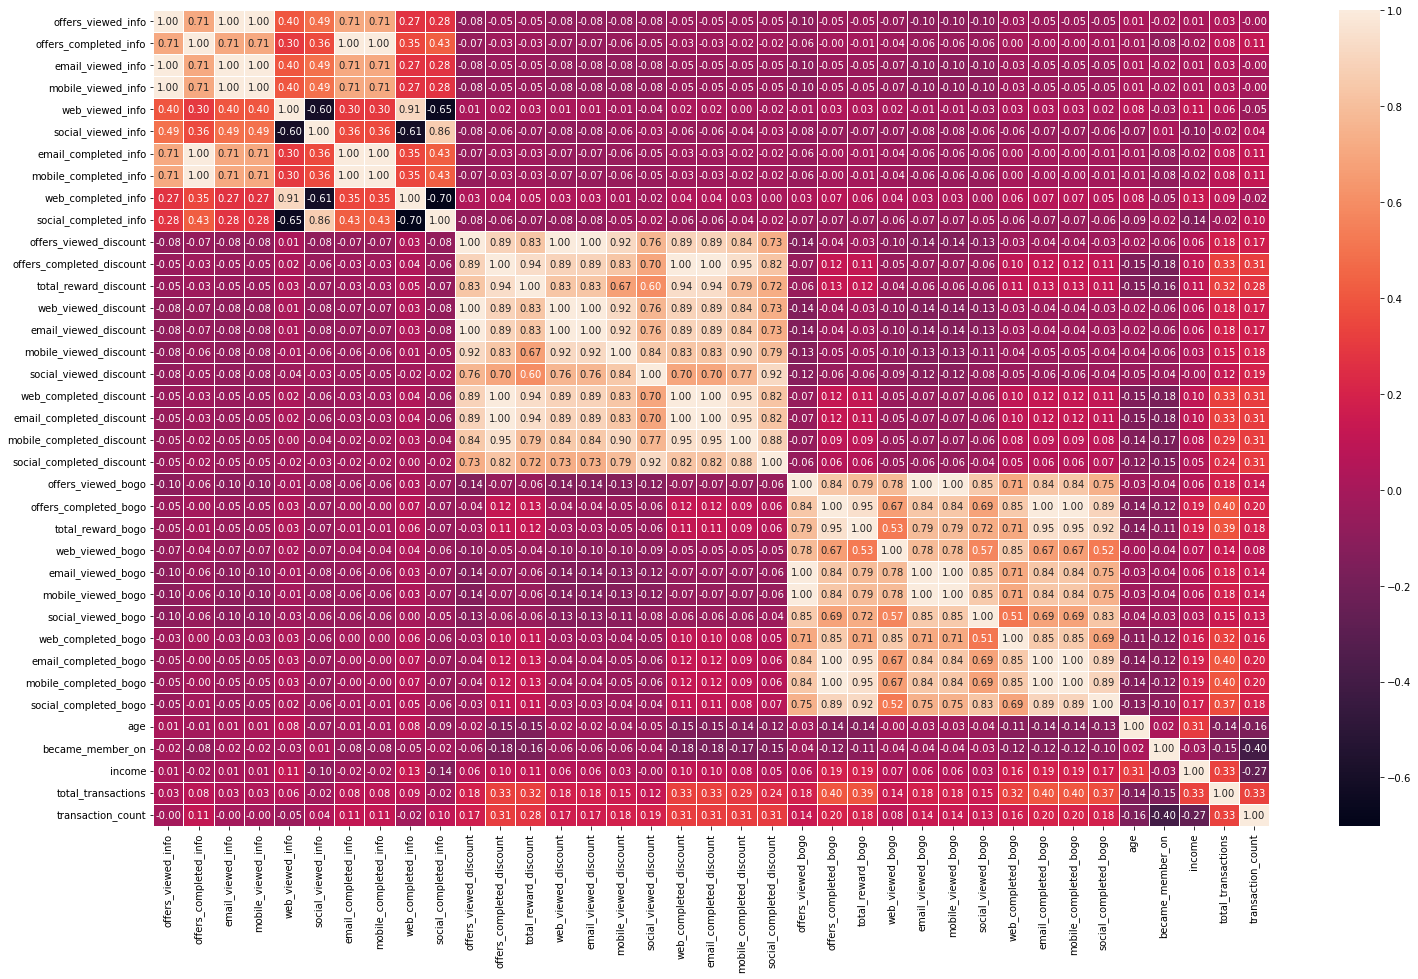

In [39]:
#let' see if we can find any correlation in this dataset
plt.figure(figsize = (25,15))
ax = sns.heatmap(person_offers_profile_df.corr(), annot=True, fmt=".2f", linewidths=.5)


We can observe the following correlation:
- total nr of transactions is correlated to completion rate for offer type BOGO and discount
- there is a correlation btw income and age
- income is correlated with BOGO completion ratio
- transaction count and income are negatively correlated but total transactions and income are positivly correlated; it appears that if the income is lower then there are more but smaller transactions 


## Question - Which gender reacts better to which offer

In [40]:
# have a look at completion rates by gender
person_offers_profile_df_ratios.groupby('gender').agg({'offers_completed_info':'sum','offers_completed_discount':'sum','offers_completed_bogo':'sum'})

,offers_completed_info,offers_completed_discount,offers_completed_bogo
gender,,,
F,2421.0,8456.0,8767.0
M,3395.0,9933.0,8794.0
O,100.0,312.0,298.0


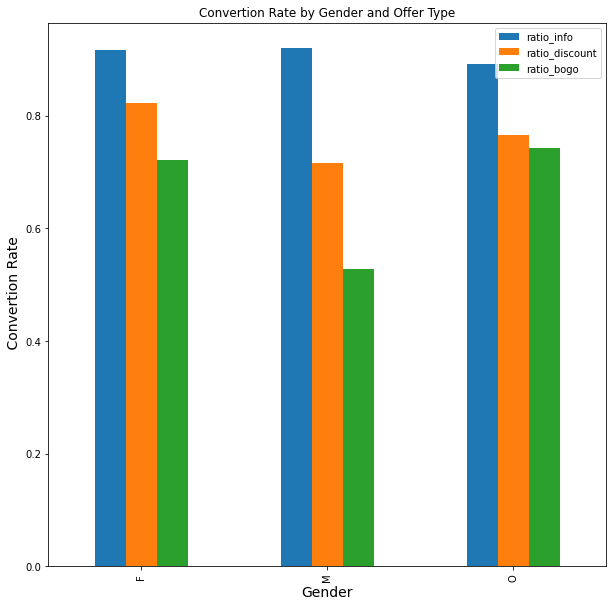

In [41]:
# average rate of offer completion per offer_type 
person_offers_profile_df_ratios.groupby('gender').agg({'ratio_info':'mean','ratio_discount':'mean','ratio_bogo':'mean'}).plot(kind='bar',figsize=(10, 10))
plt.ylabel(' Convertion Rate', fontsize=14)
plt.xlabel('Gender', fontsize=14)
plt.title("Convertion Rate by Gender and Offer Type");
plt.show()

 Based on above we can notice that Female are more likely to take discount and BOGO than men, but informational offer completion rates are the same 

In [42]:
# have a look at range of ages
person_offers_profile_df_ratios.age.unique()

array([ 53,  39,  25,  56,  57,  44,  63,  46,  91,  77,  69, 118,  34,
        22,  54, 100,  76,  70,  33,  29,  66,  59,  72,  38,  40,  23,
        71,  68,  50,  67,  95,  36,  48,  62,  58,  32,  47,  24,  61,
        60,  89,  28,  55,  81,  20,  43,  52,  35,  21,  74,  87,  80,
        84,  49,  42,  83,  51,  45,  30,  31,  65,  26,  75,  37,  41,
        19,  86,  73, 101,  93,  27,  79,  64,  92,  82,  18,  78,  85,
        94,  98,  88,  90,  96,  97,  99], dtype=int64)

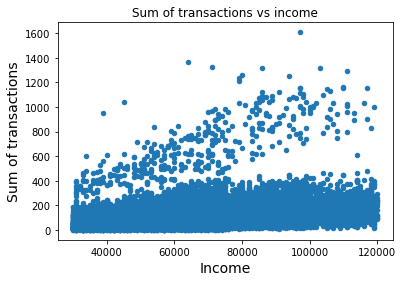

0.32974936857285697

In [43]:
# graph income vs total transactions
person_offers_profile_df_ratios.plot.scatter(x='income',y='total_transactions', colormap='viridis')
plt.ylabel('Sum of transactions', fontsize=14)
plt.xlabel('Income', fontsize=14)
plt.title("Sum of transactions vs income");
plt.show()
person_offers_profile_df_ratios['income'].corr(person_offers_profile_df_ratios['total_transactions']) 


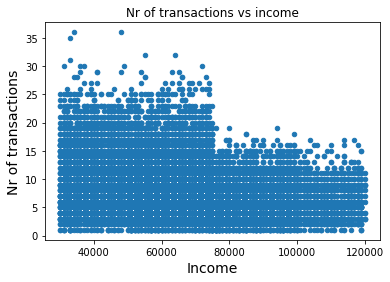

-0.2657618430039989

In [44]:
# graph income vs total transactions
person_offers_profile_df_ratios.plot.scatter(x='income',y='transaction_count')
plt.ylabel('Nr of transactions', fontsize=14)
plt.xlabel('Income', fontsize=14)
plt.title("Nr of transactions vs income");
plt.show()
person_offers_profile_df_ratios['income'].corr(person_offers_profile_df_ratios['transaction_count']) 

<AxesSubplot:xlabel='income', ylabel='ratio_discount'>

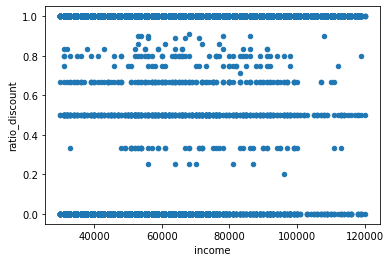

In [45]:
#income versus discount offers
person_offers_profile_df_ratios.plot.scatter(x='income',y='ratio_discount')



<AxesSubplot:xlabel='income', ylabel='ratio_bogo'>

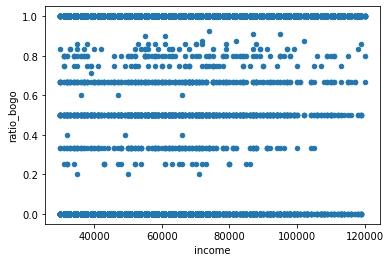

In [46]:
#income versus bogo offers
person_offers_profile_df_ratios.plot.scatter(x='income',y='ratio_bogo')


In [47]:
# have a look at completion rates by age

age_bins = np.arange(5, 116, 10)
ages_df = person_offers_profile_df_ratios.groupby(pd.cut(person_offers_profile_df_ratios["age"], age_bins)).sum()
ages_df = calc_ratios(ages_df)
ages_df

,offers_viewed_info,offers_completed_info,email_viewed_info,mobile_viewed_info,web_viewed_info,social_viewed_info,email_completed_info,mobile_completed_info,web_completed_info,social_completed_info,...,email_ratio_bogo,email_ratio,social_ratio_info,social_ratio_discount,social_ratio_bogo,social_ratio,mobile_ratio_info,mobile_ratio_discount,mobile_ratio_bogo,mobile_ratio
age,,,,,,,,,,,,,,,,,,,,,
"(5, 15]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(15, 25]",602.0,423.0,602.0,602.0,152.0,450.0,423.0,423.0,123.0,300.0,...,0.516949,0.545571,0.666667,0.744639,0.485483,0.509379,0.702658,0.749172,0.516949,0.545571
"(25, 35]",754.0,569.0,754.0,754.0,218.0,536.0,569.0,569.0,177.0,392.0,...,0.555209,0.583873,0.731343,0.785284,0.516293,0.542115,0.754642,0.783276,0.555209,0.583873
"(35, 45]",1331.0,839.0,1331.0,1331.0,511.0,820.0,839.0,839.0,323.0,516.0,...,0.658537,0.654062,0.629268,0.820093,0.621960,0.622871,0.630353,0.822808,0.658537,0.654062
"(45, 55]",2076.0,1267.0,2076.0,2076.0,805.0,1271.0,1267.0,1267.0,502.0,765.0,...,0.727080,0.708956,0.601888,0.839789,0.700543,0.688579,0.610308,0.827553,0.727080,0.708956
"(55, 65]",2083.0,1254.0,2083.0,2083.0,816.0,1267.0,1254.0,1254.0,514.0,740.0,...,0.721334,0.703375,0.584057,0.834287,0.703243,0.689605,0.602016,0.838195,0.721334,0.703375
"(65, 75]",1439.0,896.0,1439.0,1439.0,559.0,880.0,896.0,896.0,348.0,548.0,...,0.705116,0.692718,0.622727,0.832762,0.680902,0.674187,0.622655,0.834184,0.705116,0.692718
"(75, 85]",765.0,488.0,765.0,765.0,312.0,453.0,488.0,488.0,207.0,281.0,...,0.745536,0.728372,0.620309,0.842539,0.726077,0.713458,0.637908,0.840909,0.745536,0.728372
"(85, 95]",283.0,164.0,283.0,283.0,103.0,180.0,164.0,164.0,57.0,107.0,...,0.750873,0.726637,0.594444,0.869295,0.733607,0.718370,0.579505,0.859060,0.750873,0.726637


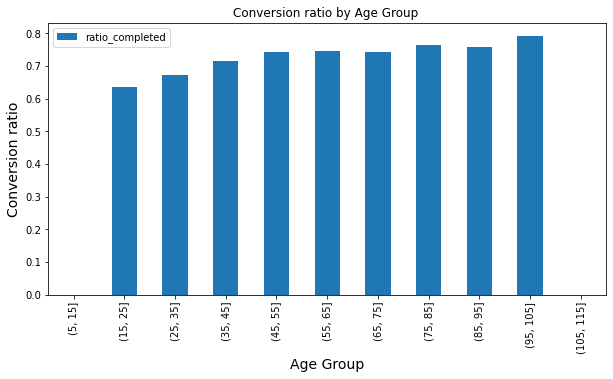

In [48]:
#conversion rate of offers by  age
ages_df.plot(by='age',figsize=(10, 5), y =['ratio_completed'],kind='bar');
plt.ylabel('Conversion ratio', fontsize=14)
plt.xlabel('Age Group', fontsize=14)
plt.title("Conversion ratio by Age Group ");
plt.show()

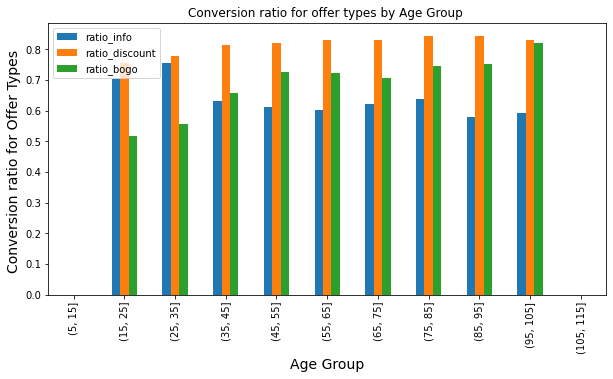

In [49]:
#conversion rate of offers by  age for each offer type 
ages_df.plot(by='age',figsize=(10, 5), y =['ratio_info','ratio_discount','ratio_bogo'],kind='bar');
plt.ylabel('Conversion ratio for Offer Types ', fontsize=14)
plt.xlabel('Age Group', fontsize=14)
plt.title("Conversion ratio for offer types by Age Group ");
plt.show()

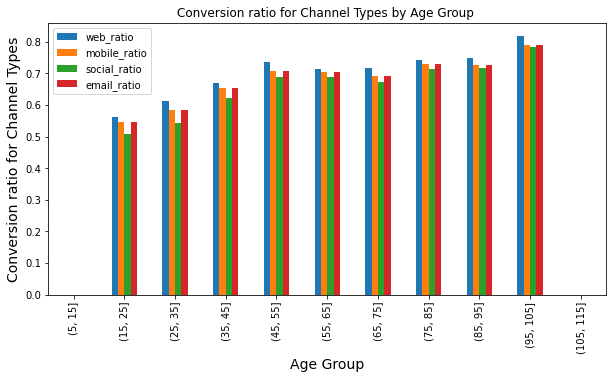

In [50]:
#conversion rate of offers by  age for each channel
ages_df.plot(by='age',figsize=(10, 5),y =['web_ratio','mobile_ratio','social_ratio','email_ratio'],kind='bar');
plt.ylabel('Conversion ratio for Channel Types', fontsize=14)
plt.xlabel('Age Group', fontsize=14)
plt.title("Conversion ratio for Channel Types by Age Group ");
plt.show()


In [51]:
# lets have a look at range of incomes
np.sort(person_offers_profile_df_ratios['income'].unique())

array([ 30000.,  31000.,  32000.,  33000.,  34000.,  35000.,  36000.,
        37000.,  38000.,  39000.,  40000.,  41000.,  42000.,  43000.,
        44000.,  45000.,  46000.,  47000.,  48000.,  49000.,  50000.,
        51000.,  52000.,  53000.,  54000.,  55000.,  56000.,  57000.,
        58000.,  59000.,  60000.,  61000.,  62000.,  63000.,  64000.,
        65000.,  66000.,  67000.,  68000.,  69000.,  70000.,  71000.,
        72000.,  73000.,  74000.,  75000.,  76000.,  77000.,  78000.,
        79000.,  80000.,  81000.,  82000.,  83000.,  84000.,  85000.,
        86000.,  87000.,  88000.,  89000.,  90000.,  91000.,  92000.,
        93000.,  94000.,  95000.,  96000.,  97000.,  98000.,  99000.,
       100000., 101000., 102000., 103000., 104000., 105000., 106000.,
       107000., 108000., 109000., 110000., 111000., 112000., 113000.,
       114000., 115000., 116000., 117000., 118000., 119000., 120000.,
           nan])

In [52]:
# lets look at conversion rates vs income groups

income_bins = np.arange(30000, 120001, 10000)
income_df = person_offers_profile_df_ratios.groupby(pd.cut(person_offers_profile_df_ratios["income"], income_bins)).sum()
income_df = calc_ratios(income_df)
income_df

,offers_viewed_info,offers_completed_info,email_viewed_info,mobile_viewed_info,web_viewed_info,social_viewed_info,email_completed_info,mobile_completed_info,web_completed_info,social_completed_info,...,email_ratio_bogo,email_ratio,social_ratio_info,social_ratio_discount,social_ratio_bogo,social_ratio,mobile_ratio_info,mobile_ratio_discount,mobile_ratio_bogo,mobile_ratio
income,,,,,,,,,,,,,,,,,,,,,
"(30000, 40000]",1155.0,810.0,1155.0,1155.0,315.0,840.0,810.0,810.0,220.0,590.0,...,0.484903,0.517033,0.702381,0.740950,0.439153,0.473118,0.701299,0.740905,0.484903,0.517033
"(40000, 50000]",1099.0,776.0,1099.0,1099.0,275.0,824.0,776.0,776.0,198.0,578.0,...,0.511790,0.541778,0.701456,0.768543,0.478571,0.508464,0.706096,0.762222,0.511790,0.541778
"(50000, 60000]",1848.0,1225.0,1848.0,1848.0,688.0,1160.0,1225.0,1225.0,462.0,763.0,...,0.664220,0.664002,0.657759,0.797081,0.635196,0.638071,0.662879,0.799625,0.664220,0.664002
"(60000, 70000]",1607.0,1071.0,1607.0,1607.0,665.0,942.0,1071.0,1071.0,457.0,614.0,...,0.677201,0.675457,0.651805,0.812719,0.642291,0.643447,0.666459,0.818780,0.677201,0.675457
"(70000, 80000]",1406.0,822.0,1406.0,1406.0,593.0,813.0,822.0,822.0,356.0,466.0,...,0.775384,0.747100,0.573186,0.874847,0.759410,0.739101,0.584637,0.870044,0.775384,0.747100
"(80000, 90000]",879.0,474.0,879.0,879.0,392.0,487.0,474.0,474.0,233.0,241.0,...,0.828352,0.786686,0.494867,0.897919,0.821898,0.787253,0.539249,0.889851,0.828352,0.786686
"(90000, 100000]",821.0,452.0,821.0,821.0,367.0,454.0,452.0,452.0,222.0,230.0,...,0.844882,0.799245,0.506608,0.865777,0.841235,0.804018,0.550548,0.856380,0.844882,0.799245
"(100000, 110000]",273.0,131.0,273.0,273.0,96.0,177.0,131.0,131.0,50.0,81.0,...,0.843645,0.795222,0.457627,0.920968,0.842448,0.802685,0.479853,0.916667,0.843645,0.795222
"(110000, 120000]",225.0,116.0,225.0,225.0,82.0,143.0,116.0,116.0,47.0,69.0,...,0.890493,0.845787,0.482517,0.917184,0.883081,0.847214,0.515556,0.908475,0.890493,0.845787


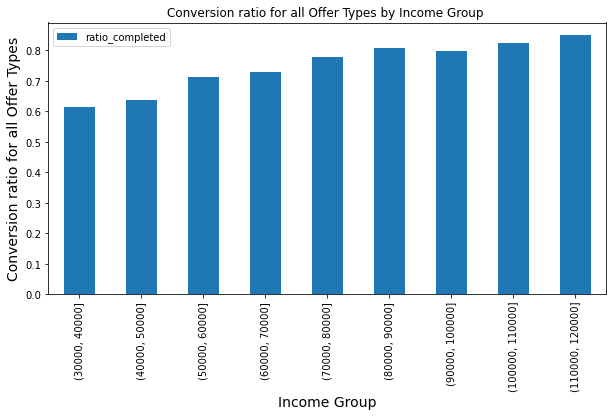

In [53]:
#conversion rate of offers by  income
income_df.plot(by='income',figsize=(10, 5),y =['ratio_completed'],kind='bar');
plt.ylabel('Conversion ratio for all Offer Types', fontsize=14)
plt.xlabel('Income Group', fontsize=14)
plt.title("Conversion ratio for all Offer Types by Income Group ");
plt.show()


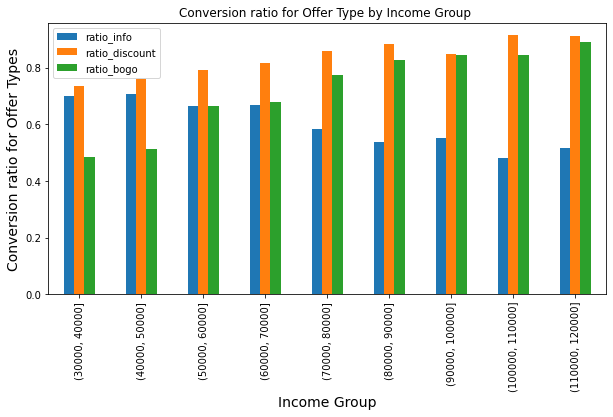

In [54]:
#conversion rate of offers by  income for each offer type

income_df.plot(by='income',figsize=(10, 5),y =['ratio_info','ratio_discount','ratio_bogo'],kind='bar');
plt.ylabel('Conversion ratio for Offer Types', fontsize=14)
plt.xlabel('Income Group', fontsize=14)
plt.title("Conversion ratio for Offer Type by Income Group ");
plt.show()



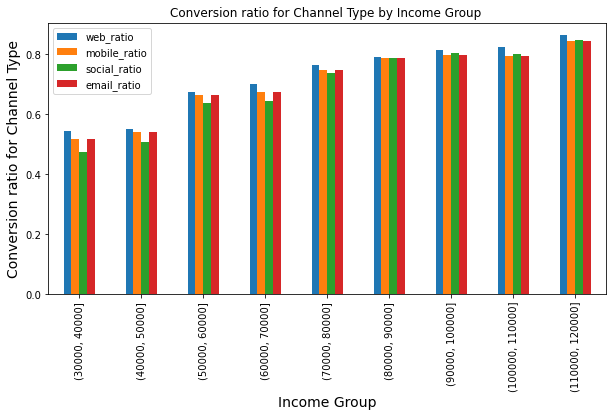

In [55]:
#conversion rate of offers by  income for each channel type

income_df.plot(by='income',figsize=(10, 5),y =['web_ratio','mobile_ratio','social_ratio','email_ratio'],kind='bar');
plt.ylabel('Conversion ratio for Channel Type', fontsize=14)
plt.xlabel('Income Group', fontsize=14)
plt.title("Conversion ratio for Channel Type by Income Group ");
plt.show()


In [56]:
# lets look at if days person has been a member has an effect on completion ratios

from datetime import datetime

np.sort(person_offers_profile_df_ratios['became_member_on'].unique())


# convert became_member_on to days that they have been a member assuming today is 2019-01-01 
person_offers_profile_df_ratios['days_member'] = person_offers_profile_df_ratios['became_member_on'].apply(
    lambda x: (
        datetime(2019, 1, 1) - datetime.strptime(str(x), '%Y%m%d')).days
)

np.sort(person_offers_profile_df_ratios['days_member'].unique())

array([ 159,  160,  161, ..., 1980, 1981, 1982], dtype=int64)

In [57]:
# group data into bins 

days_member_bins = np.arange(100, 1990, 100)
days_member_df = person_offers_profile_df_ratios.groupby(pd.cut(person_offers_profile_df_ratios["days_member"], days_member_bins)).sum()
days_member_df = calc_ratios(days_member_df)
days_member_df

,offers_viewed_info,offers_completed_info,email_viewed_info,mobile_viewed_info,web_viewed_info,social_viewed_info,email_completed_info,mobile_completed_info,web_completed_info,social_completed_info,...,email_ratio,social_ratio_info,social_ratio_discount,social_ratio_bogo,social_ratio,mobile_ratio_info,mobile_ratio_discount,mobile_ratio_bogo,mobile_ratio,days_member
days_member,,,,,,,,,,,,,,,,,,,,,
"(100, 200]",507.0,227.0,507.0,507.0,194.0,313.0,227.0,227.0,88.0,139.0,...,0.400322,0.444089,0.494845,0.364477,0.374545,0.447732,0.493840,0.391070,0.400322,145341
"(200, 300]",1203.0,494.0,1203.0,1203.0,459.0,744.0,494.0,494.0,198.0,296.0,...,0.402291,0.397849,0.525834,0.369633,0.373211,0.410640,0.525180,0.400653,0.402291,478011
"(300, 400]",1493.0,785.0,1493.0,1493.0,536.0,957.0,785.0,785.0,282.0,503.0,...,0.493700,0.525601,0.633882,0.463189,0.470980,0.525787,0.633365,0.487793,0.493700,865796
"(400, 500]",1793.0,967.0,1793.0,1793.0,677.0,1116.0,967.0,967.0,359.0,608.0,...,0.546310,0.544803,0.669979,0.526381,0.528609,0.539320,0.663083,0.547619,0.546310,1249997
"(500, 600]",938.0,649.0,938.0,938.0,348.0,590.0,649.0,649.0,246.0,403.0,...,0.681354,0.683051,0.813173,0.655072,0.658562,0.691898,0.803766,0.679352,0.681354,752601
"(600, 700]",615.0,446.0,615.0,615.0,235.0,380.0,446.0,446.0,174.0,272.0,...,0.793643,0.715789,0.922768,0.791995,0.783547,0.725203,0.905910,0.805131,0.793643,617452
"(700, 800]",579.0,418.0,579.0,579.0,214.0,365.0,418.0,418.0,160.0,258.0,...,0.793438,0.706849,0.937864,0.788136,0.778855,0.721934,0.923019,0.805459,0.793438,685388
"(800, 900]",625.0,445.0,625.0,625.0,249.0,376.0,445.0,445.0,183.0,262.0,...,0.781475,0.696809,0.929825,0.780471,0.770833,0.712000,0.916185,0.794239,0.781475,806355
"(900, 1000]",662.0,479.0,662.0,662.0,267.0,395.0,479.0,479.0,213.0,266.0,...,0.777751,0.673418,0.947222,0.778955,0.766037,0.723565,0.931612,0.788000,0.777751,934751


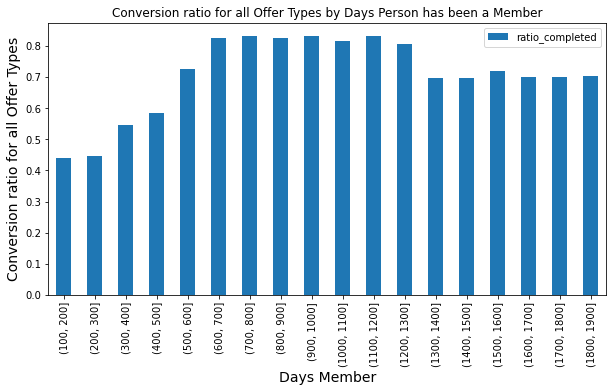

In [58]:
#conversion rate of offers by member days
days_member_df.plot(by='days_member',figsize=(10, 5),y =['ratio_completed'],kind='bar');
plt.ylabel('Conversion ratio for all Offer Types', fontsize=14)
plt.xlabel('Days Member', fontsize=14)
plt.title("Conversion ratio for all Offer Types by Days Person has been a Member");
plt.show()

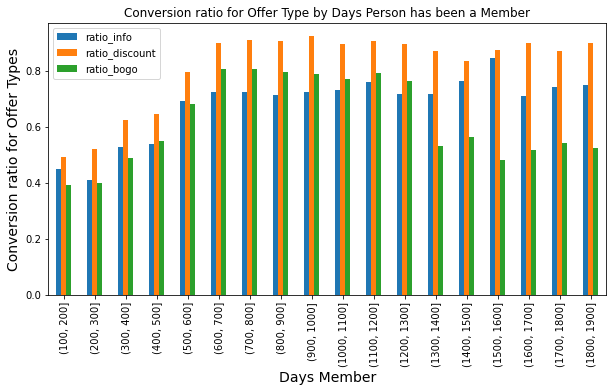

In [59]:
#conversion rate of offers by member days for each offer type
days_member_df.plot(by='days_member',figsize=(10, 5),y =['ratio_info','ratio_discount','ratio_bogo'],kind='bar');
plt.ylabel('Conversion ratio for Offer Types', fontsize=14)
plt.xlabel('Days Member', fontsize=14)
plt.title("Conversion ratio for Offer Type by Days Person has been a Member");
plt.show()

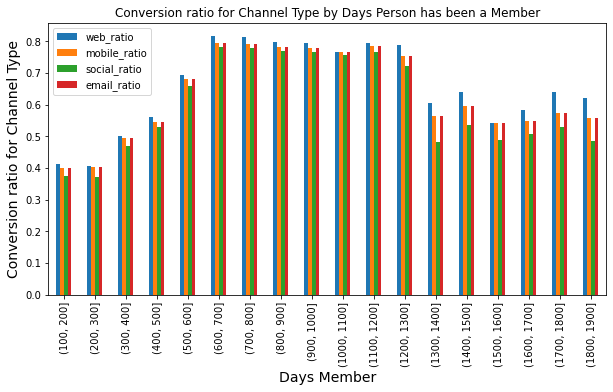

In [60]:
#conversion rate of offers by member days for each channel type
days_member_df.plot(by='days_member',figsize=(10, 5),y =['web_ratio','mobile_ratio','social_ratio','email_ratio'],kind='bar');
plt.ylabel('Conversion ratio for Channel Type', fontsize=14)
plt.xlabel('Days Member', fontsize=14)
plt.title("Conversion ratio for Channel Type by Days Person has been a Member");
plt.show()

In [61]:
# lets have a look at range of incomes
np.sort(person_offers_profile_df_ratios['transaction_count'].unique())

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 35., 36., nan])

In [62]:
# group data into bins 

transaction_bins = np.arange(0, 41, 10)
transaction_df = person_offers_profile_df_ratios.groupby(pd.cut(person_offers_profile_df_ratios["transaction_count"], transaction_bins)).sum()
transaction_df = calc_ratios(transaction_df)
transaction_df

,offers_viewed_info,offers_completed_info,email_viewed_info,mobile_viewed_info,web_viewed_info,social_viewed_info,email_completed_info,mobile_completed_info,web_completed_info,social_completed_info,...,email_ratio,social_ratio_info,social_ratio_discount,social_ratio_bogo,social_ratio,mobile_ratio_info,mobile_ratio_discount,mobile_ratio_bogo,mobile_ratio,days_member
transaction_count,,,,,,,,,,,,,,,,,,,,,
"(0, 10]",7583.0,4117.0,7583.0,7583.0,2955.0,4628.0,4117.0,4117.0,1700.0,2417.0,...,0.575602,0.522256,0.688522,0.557624,0.553091,0.542925,0.689599,0.582138,0.575602,6968576
"(10, 20]",2774.0,2389.0,2774.0,2774.0,993.0,1781.0,2389.0,2389.0,873.0,1516.0,...,0.765332,0.851207,0.951295,0.723283,0.737052,0.861211,0.939098,0.750393,0.765332,3837124
"(20, 30]",212.0,199.0,212.0,212.0,67.0,145.0,199.0,199.0,67.0,132.0,...,0.667462,0.910345,0.990436,0.610843,0.634903,0.938679,0.980714,0.636943,0.667462,428914
"(30, 40]",3.0,3.0,3.0,3.0,1.0,2.0,3.0,3.0,1.0,2.0,...,0.760000,1.000000,1.000000,0.571429,0.625000,1.000000,1.000000,0.727273,0.760000,6960


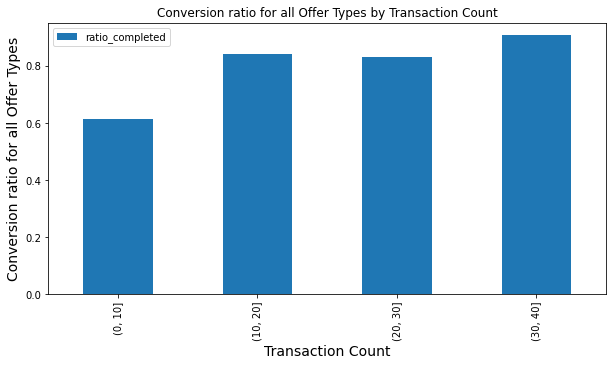

In [63]:
#conversion rate of offers by transactions
transaction_df.plot(by='transaction_count',figsize=(10, 5),y =['ratio_completed'],kind='bar');
plt.ylabel('Conversion ratio for all Offer Types', fontsize=14)
plt.xlabel('Transaction Count', fontsize=14)
plt.title("Conversion ratio for all Offer Types by Transaction Count");
plt.show()


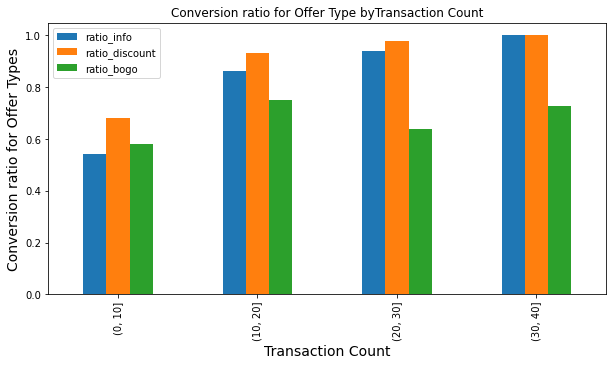

In [64]:
#conversion rate of offers by member days for each offer type
transaction_df.plot(by='transaction_count',figsize=(10, 5),y =['ratio_info','ratio_discount','ratio_bogo'],kind='bar');
plt.ylabel('Conversion ratio for Offer Types', fontsize=14)
plt.xlabel('Transaction Count', fontsize=14)
plt.title("Conversion ratio for Offer Type byTransaction Count");
plt.show()

# LinearRegression

In [65]:
# list columns for convenience
person_offers_profile_df_ratios.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16834 entries, 0 to 16833
Data columns (total 61 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   person                     16834 non-null  object 
 1   offers_viewed_info         8251 non-null   float64
 2   offers_completed_info      5597 non-null   float64
 3   email_viewed_info          8251 non-null   float64
 4   mobile_viewed_info         8251 non-null   float64
 5   web_viewed_info            8251 non-null   float64
 6   social_viewed_info         8251 non-null   float64
 7   email_completed_info       5597 non-null   float64
 8   mobile_completed_info      5597 non-null   float64
 9   web_completed_info         5597 non-null   float64
 10  social_completed_info      5597 non-null   float64
 11  offers_viewed_discount     12676 non-null  float64
 12  offers_completed_discount  12676 non-null  float64
 13  total_reward_discount      12676 non-null  flo

In [66]:
# fill in na income levels with mean
person_offers_profile_df_ratios['income'].fillna((person_offers_profile_df_ratios['income'].mean()), inplace=True)
person_offers_profile_df_ratios['income'] = person_offers_profile_df_ratios['income'].astype(int)

# fill in na age with mean
person_offers_profile_df_ratios['age']=person_offers_profile_df_ratios['age'].apply(lambda x: None if x == 118 else x)
person_offers_profile_df_ratios['age'].fillna(int((person_offers_profile_df_ratios['age'].mean())), inplace=True)
person_offers_profile_df_ratios['age'] = person_offers_profile_df_ratios['age'].astype(int)



In [67]:
# how many na ratios for info offers
person_offers_profile_df_ratios['ratio_info'].isna().sum()

11237

In [68]:
# fill na transactions with 0 
person_offers_profile_df_ratios['total_transactions'].fillna(0, inplace=True)
person_offers_profile_df_ratios['transaction_count'].fillna(0, inplace=True)

In [69]:
# make separate dfs for each offer type without rows with na for corresponding conversion ratio
person_offers_profile_df_info = person_offers_profile_df_ratios[person_offers_profile_df_ratios['ratio_info'].notna()]
person_offers_profile_df_bogo = person_offers_profile_df_ratios[person_offers_profile_df_ratios['ratio_bogo'].notna()]
person_offers_profile_df_discount = person_offers_profile_df_ratios[person_offers_profile_df_ratios['ratio_discount'].notna()]


person_offers_profile_df_info['ratio_info'] = person_offers_profile_df_info['ratio_info'].apply(lambda x: x*30630600).astype(int)
person_offers_profile_df_bogo['ratio_bogo'] = person_offers_profile_df_bogo['ratio_bogo'].apply(lambda x: x*30630600).astype(int)
person_offers_profile_df_discount['ratio_discount'] = person_offers_profile_df_discount['ratio_discount'].apply(lambda x: x*30630600).astype(int)

C:\Users\dianas\AppData\Local\Temp/ipykernel_34848/2223761991.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  person_offers_profile_df_info['ratio_info'] = person_offers_profile_df_info['ratio_info'].apply(lambda x: x*30630600).astype(int)
C:\Users\dianas\AppData\Local\Temp/ipykernel_34848/2223761991.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  person_offers_profile_df_bogo['ratio_bogo'] = person_offers_profile_df_bogo['ratio_bogo'].apply(lambda x: x*30630600).astype(int)
C:\Users\dianas\AppData\

In [70]:
# function for LinearRegression

def DoLinearRegression1(df, offer_suffix):
    '''
    This function checks if channel in the list of channels and event is not NA
    
    Inputs:
    df - dataframe for train and test data
    offer_suffix - offer type
    
    Outputs:
    prints r2 score and plots the results
    '''
    X=df[['age','days_member','income','gender']]
    X = pd.get_dummies(data=X, drop_first=False)
    y=df['ratio_' + offer_suffix]

    #Split into train and test
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30, random_state=42)

    ####Four steps:
    #Instantiate 
    lm_model=LinearRegression(normalize=True) 

    #Fit the model to the training data
    lm_model.fit(X_train,y_train) 

    #Predict using test data
    y_preds=lm_model.predict(X_test)

    #Score
    r2_test=r2_score(y_test,y_preds)
    print(r2_test)

    sns.regplot(y_test,y_preds);

    
def DoLinearRegression2(df, offer_suffix):
    '''
    This function checks if channel in the list of channels and event is not NA
    
    Inputs:
    df - dataframe for train and test data
    offer_suffix - offer type
    
    Outputs:
    prints r2 score and plots the results
    '''
    X=df[['age','days_member','income','gender','offers_viewed_' + offer_suffix,'total_transactions','transaction_count']]
    X = pd.get_dummies(data=X, drop_first=False)
    y=df['ratio_' + offer_suffix]

    #Split into train and test
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30, random_state=42)

    ####Four steps:
    #Instantiate 
    lm_model=LinearRegression(normalize=True) 

    #Fit the model to the training data
    lm_model.fit(X_train,y_train) 

    #Predict using test data
    y_preds=lm_model.predict(X_test)

    #Score
    r2_test=r2_score(y_test,y_preds)
    print(r2_test)

    sns.regplot(y_test,y_preds);

    
def DoLogisticRegression(df, offer_suffix):
    '''
    This function checks if channel in the list of channels and event is not NA
    
    Inputs:
    df - dataframe for train and test data
    offer_suffix - offer type
    
    Outputs:
    prints r2 score and plots the results
    '''
    X=df[['age','days_member','income','gender','offers_viewed_' + offer_suffix,'total_transactions','transaction_count']]
    X = pd.get_dummies(data=X, drop_first=False)
    y=df['ratio_' + offer_suffix]

    #Split into train and test
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30, random_state=42)

    # scaler
    scaler = MinMaxScaler()
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    
    ####Four steps:
    #Instantiate 
    
    model=LogisticRegression(solver='liblinear') 
    
    #fit the model to the training data
    model.fit(X_train, y_train)
    
    #create predictions using test data
    y_preds = model.predict(X_test)
    #print summary statistics
    print(precision_score(y_test, y_preds,average='micro'))
    #print(recall_score(y_test, y_preds,average='micro'))
    #print(accuracy_score(y_test, y_preds))
    labels=np.unique(y_preds)
    #print(confusion_matrix(y_test, y_preds, labels=labels))


C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\dianas\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.014258325807783634


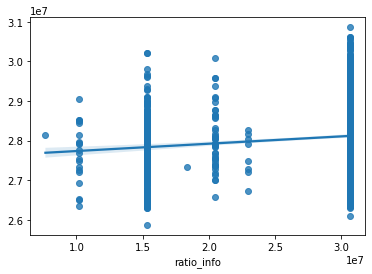

In [71]:
# run linear regression on info offers
DoLinearRegression1(person_offers_profile_df_info, 'info')

C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\dianas\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.2436104399107034


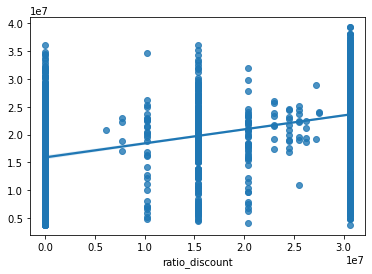

In [72]:
# run linear regression on discount offers
DoLinearRegression1(person_offers_profile_df_discount, 'discount')

C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\dianas\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.24762532620366284


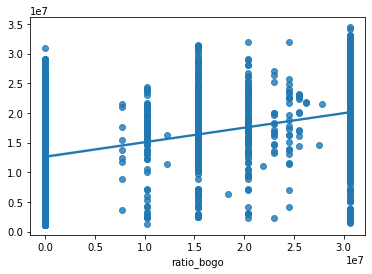

In [73]:
# run linear regression on bogo offers
DoLinearRegression1(person_offers_profile_df_bogo, 'bogo')

C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\dianas\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.4268833363068061


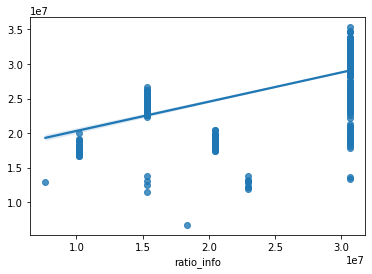

In [74]:
DoLinearRegression2(person_offers_profile_df_info, 'info')

C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\dianas\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.4046200807240524


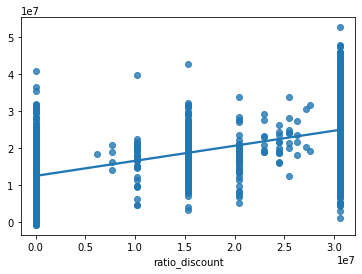

In [75]:
# run linear regression on discount offers
DoLinearRegression2(person_offers_profile_df_discount, 'discount')

C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\dianas\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.38178096330298295


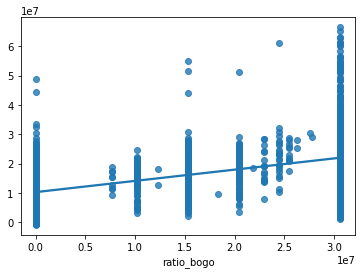

In [76]:
# run linear regression on bogo offers
DoLinearRegression2(person_offers_profile_df_bogo, 'bogo')

In [77]:
DoLogisticRegression(person_offers_profile_df_info, 'info')

0.8101190476190476


In [78]:
DoLogisticRegression(person_offers_profile_df_bogo, 'bogo')

0.7549369497977635


In [79]:
DoLogisticRegression(person_offers_profile_df_discount, 'discount')

0.790954509597686


In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

def display_results(cv, y_test, y_pred):
    labels=np.unique(y_pred)
    confusion_mat=confusion_matrix(y_test, y_pred, labels=labels)
    accuracy=(y_pred==y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)
    print("\nBest Parameters:", cv.best_params_)
    
    print(classification_report(y_test, y_pred))

def DoLogisticRegressionWithGridsearch(df, offer_suffix):
    '''
    This function checks if channel in the list of channels and event is not NA
    
    Inputs:
    df - dataframe for train and test data
    offer_suffix - offer type
    
    Outputs:
    prints r2 score and plots the results
    '''
    X=df[['age','days_member','income','gender','offers_viewed_' + offer_suffix,'total_transactions','transaction_count']]
    X = pd.get_dummies(data=X, drop_first=False)
    y=df['ratio_' + offer_suffix]

    #Split into train and test
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30, random_state=42)

    # scaler
    scaler = MinMaxScaler()
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    
    ####Four steps:
    #Instantiate 
    
    #model=LogisticRegression(solver='liblinear') 
    
    pipe = Pipeline([('classifier' , RandomForestClassifier())])
    # pipe = Pipeline([('classifier', RandomForestClassifier())])

    # Create param grid.

    param_grid = [
        {'classifier' : [LogisticRegression()],
         'classifier__penalty' : ['l1', 'l2'],
        'classifier__C' : np.logspace(-4, 4, 20),
        'classifier__solver' : ['liblinear']},
        {'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : list(range(10,101,10)),
        'classifier__max_features' : list(range(6,32,5))}
    ]

    # Create grid search object

    cv = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

    # Fit on data

    best_cv = cv.fit(X_train, y_train)
    
    print(best_cv)
    
    #fit the model to the training data
    #model.fit(X_train, y_train)
    
    #create predictions using test data
    y_pred = cv.predict(X_test)
    display_results(cv, y_test, y_pred)
    #print(classification_report(y_test, y_pred))
    #y_preds = model.predict(X_test)
    #print summary statistics
    #print(precision_score(y_test, y_preds,average='micro'))
    #print(recall_score(y_test, y_preds,average='micro'))
    #print(accuracy_score(y_test, y_preds))
    #labels=np.unique(y_preds)
    #print(confusion_matrix(y_test, y_preds, labels=labels))

    



#cv = GridSearchCV(pipeline, param_grid=parameters, refit=True)

In [96]:
DoLogisticRegressionWithGridsearch(person_offers_profile_df_info, 'info')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
250 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_est

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1....759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'classifier__penalty': ['l1', 'l2'],
                          'classifier__solver': ['liblinear']},
                         {'classifier': [RandomForestClassifier(max_features=6,
                                                                n_estimators=80)],
                          'classifier__max_features': [6, 11, 16, 21, 26, 31],
                          'class

C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:
DoLogisticRegressionWithGridsearch(person_offers_profile_df_bogo, 'bogo')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
250 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_est

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(C=11.288378916846883,
                                                            penalty='l1',
                                                            solver='liblinear')],
                          'classifier__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147...
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'classifier__penalty': ['l1', 'l2'],
                          'classifier__solver': ['liblinear']},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__max_features

C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [98]:
DoLogisticRegressionWithGridsearch(person_offers_profile_df_discount, 'discount')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
250 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_est

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(C=29.763514416313132,
                                                            penalty='l1',
                                                            solver='liblinear')],
                          'classifier__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147...
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'classifier__penalty': ['l1', 'l2'],
                          'classifier__solver': ['liblinear']},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__max_features

C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dianas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
